## **ABOUT THE DATASET**

HAM10000 ("Human Against Machine with 10000 training images") dataset - a large collection of multi-source dermatoscopic images of pigmented lesions

The dermatoscopic images are collected from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images.

It has 7 different classes of skin cancer which are listed below :
- Melanocytic nevi
- Melanoma
- Benign keratosis-like lesions
- Basal cell carcinoma
- Actinic keratoses
- Vascular lesions
- Dermatofibroma


In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnull,input_file_name,sum as spark_sum
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from glob import glob
import os
from PIL import Image
import io

# Importing required libraries for neural network training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools

In [3]:
# Initialize Spark session
spark = SparkSession.builder \
        .appName("Project") \
        .config("spark.executor.memory","1g") \
        .getOrCreate()

HAM10000_metadata.csv file is the main csv file that includes the data of all training images, the features of which are -
 
1. Lesion_id
2. Image_id
3. save Dx
4. Dx_type
5. Age
6. Sex
7. Localization


In [4]:
# Reading the data from HAM_metadata.csv
sdf = spark.read.format("csv").option("header",True).load("hdfs://namenode:9000/project-data/HAM10000_metadata.csv")

In [5]:
# Display the first few rows of the DataFrame
sdf.show(5)

+-----------+------------+---+---------+---+------+---------------+
|  lesion_id|    image_id| dx|  dx_type|age|   sex|   localization|
+-----------+------------+---+---------+---+------+---------------+
|HAM_0000550|ISIC_0024306| nv|follow_up| 45|  male|          trunk|
|HAM_0003577|ISIC_0024307| nv|follow_up| 50|  male|lower extremity|
|HAM_0001477|ISIC_0024308| nv|follow_up| 55|female|          trunk|
|HAM_0000484|ISIC_0024309| nv|follow_up| 40|  male|          trunk|
|HAM_0003350|ISIC_0024310|mel|    histo| 60|  male|          chest|
+-----------+------------+---+---------+---+------+---------------+
only showing top 5 rows



In [6]:
# Display the data types of each column
sdf.printSchema()

root
 |-- lesion_id: string (nullable = true)
 |-- image_id: string (nullable = true)
 |-- dx: string (nullable = true)
 |-- dx_type: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- localization: string (nullable = true)



A general statistical analysis of the numerical values of dataset (here : age)

In [7]:
# Display summary statistics for numerical columns
sdf.describe().show()

+-------+-----------+------------+-----+--------+------------------+------+---------------+
|summary|  lesion_id|    image_id|   dx| dx_type|               age|   sex|   localization|
+-------+-----------+------------+-----+--------+------------------+------+---------------+
|  count|       5000|        5000| 5000|    5000|              4997|  5000|           5000|
|   mean|       NULL|        NULL| NULL|    NULL| 51.99619771863118|  NULL|           NULL|
| stddev|       NULL|        NULL| NULL|    NULL|16.807396479302238|  NULL|           NULL|
|    min|HAM_0000000|ISIC_0024306|akiec|confocal|                 0|female|        abdomen|
|    max|HAM_0007628|ISIC_0029305| vasc|   histo|                85|  male|upper extremity|
+-------+-----------+------------+-----+--------+------------------+------+---------------+



## Data Imputation



In [8]:
sdf.select([col(c).isNull().cast("int").alias(c) for c in sdf.columns]) \
  .agg(*[spark_sum(c).alias(c) for c in sdf.columns]) \
  .show()

+---------+--------+---+-------+---+---+------------+
|lesion_id|image_id| dx|dx_type|age|sex|localization|
+---------+--------+---+-------+---+---+------------+
|        0|       0|  0|      0|  3|  0|           0|
+---------+--------+---+-------+---+---+------------+



In [9]:
median_age = sdf.select('age').toPandas()['age'].median()

sdf = sdf.withColumn('age', when(isnull(col('age')), median_age).otherwise(col('age')))

In [10]:
sdf.select([col(c).isNull().cast("int").alias(c) for c in sdf.columns]) \
  .agg(*[spark_sum(col(c)).alias(c) for c in sdf.columns]) \
  .show()

+---------+--------+---+-------+---+---+------------+
|lesion_id|image_id| dx|dx_type|age|sex|localization|
+---------+--------+---+-------+---+---+------------+
|        0|       0|  0|      0|  0|  0|           0|
+---------+--------+---+-------+---+---+------------+



In [11]:
# Lesion type dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Base directory for skin images
# base_skin_dir = '../input/skin-cancer-mnist-ham10000'
base_skin_dir = 'hdfs://namenode:9000//project-data/'
# Merge images from both folders into one dictionary
image_df = spark.read.format("binaryFile").load(os.path.join(base_skin_dir, "**", "*.jpg"), recursiveFileLookup=True)

# Extract image ID and create a dictionary
imageid_path_dict = {
    os.path.splitext(os.path.basename(row.path))[0]: row.path
    for row in image_df.select(input_file_name().alias('path')).collect()
}

In [12]:
imageid_path_udf = F.udf(lambda x: imageid_path_dict.get(x))
lesion_type_udf = F.udf(lambda x: lesion_type_dict.get(x))

# Apply the UDFs to create new columns
sdf = sdf.withColumn('path', imageid_path_udf(F.col('image_id')))
sdf = sdf.withColumn('cell_type', lesion_type_udf(F.col('dx')))

# Convert to Pandas DataFrame to create 'cell_type_idx' column
df = sdf.toPandas()
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

## Image Preprocessing

Resizing of images because the original dimensions of 450 * 600 * 3 take long time to process in Neural Networks

In [13]:
def open_and_resize_image(binary_content):
    image = Image.open(io.BytesIO(binary_content))
    return np.asarray(image.resize((125, 100)))

# UDF to process each image
def process_image(row):
    binary_content = row.content
    resized_image = open_and_resize_image(binary_content)
    return resized_image

In [14]:
# Apply the processing function in parallel
df['image'] = image_df.rdd.map(lambda row: process_image(row)).collect()

In [15]:
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age              object
sex              object
localization     object
path             object
cell_type        object
cell_type_idx      int8
image            object
dtype: object

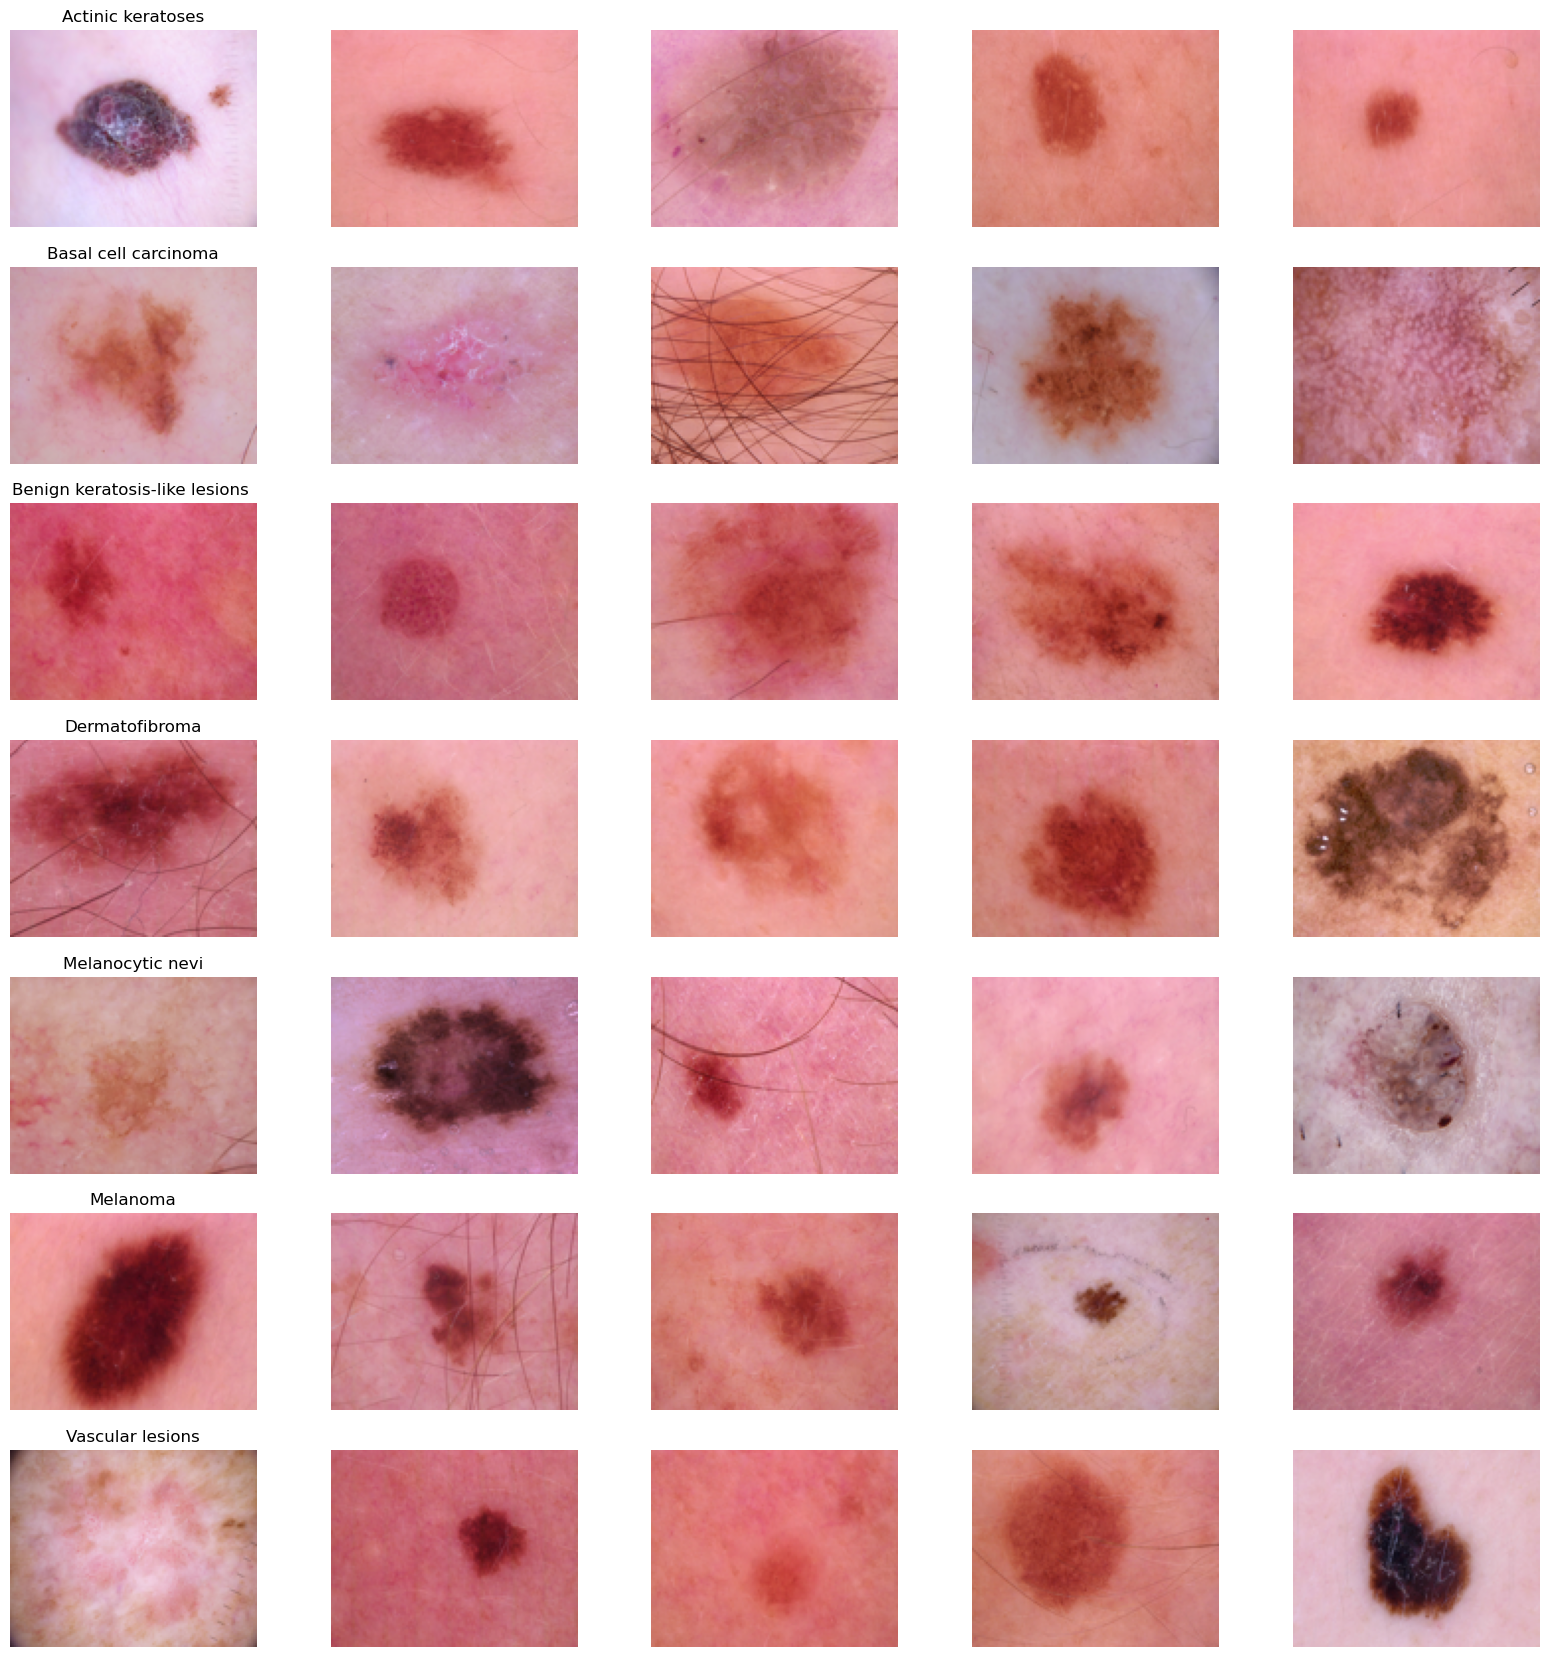

In [16]:
n_samples = 5

# Create a plot with 7 rows and n_samples columns
fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))

# Group by cell type and plot images
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

# Save the figure
fig.savefig('category_samples.png', dpi=300)

In [17]:
# Check image size distribution
image_size_counts = df['image'].map(lambda x: x.shape).value_counts()
print(image_size_counts)

image
(100, 125, 3)    5000
Name: count, dtype: int64


## **Exploratory Data Analysis**
Exploratory data analysis can help detect obvious errors, identify outliers in datasets, understand relationships, unearth important factors, find patterns within data, and provide new insights.

In [18]:
df= df[df['age'] != 0]
df= df[df['sex'] != 'unknown']

### UNIVARIATE ANALYSIS

<Axes: title={'center': 'CELL TYPE'}, xlabel='cell_type', ylabel='Count'>

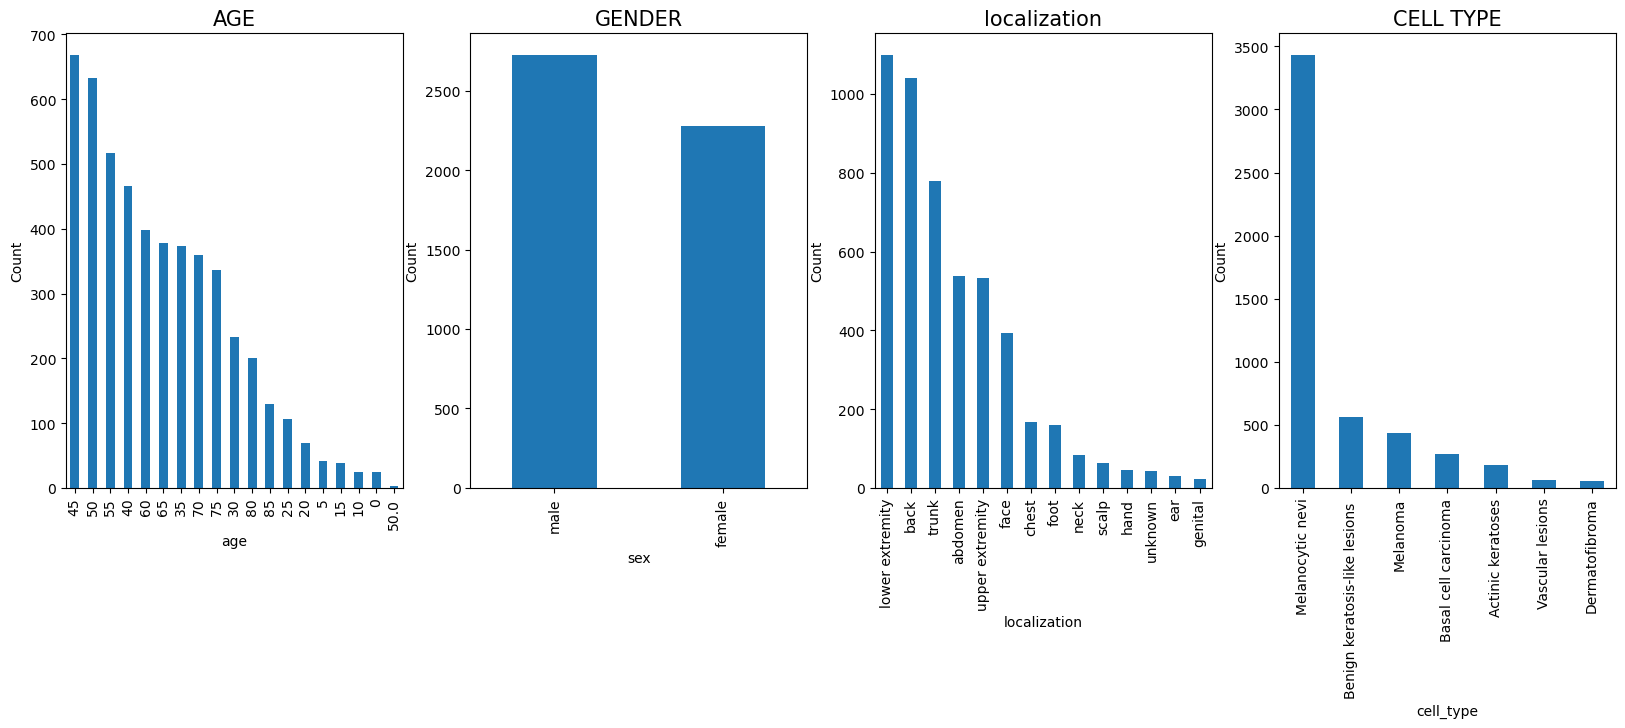

In [19]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.125, bottom=1, right=0.9, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
df['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Count")
df['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("localization",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
df['localization'].value_counts().plot.bar()

plt.subplot(2,4,4)
plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
df['cell_type'].value_counts().plot.bar()

1. Skin diseases are found to be maximum in people aged around 45. Minimum for 10 and below. We also observe that the probability of having skin disease increases with the increase in age.
2. Skin diseases are more prominent in Men as compared to Women and other gender.
3. Skin diseases are more visible on the "back" of the body and least on the "acral surfaces"(such as limbs, fingers, or ears).
4. The most found disease among people is Melanocytic nevi while the least found is Dermatofibroma.

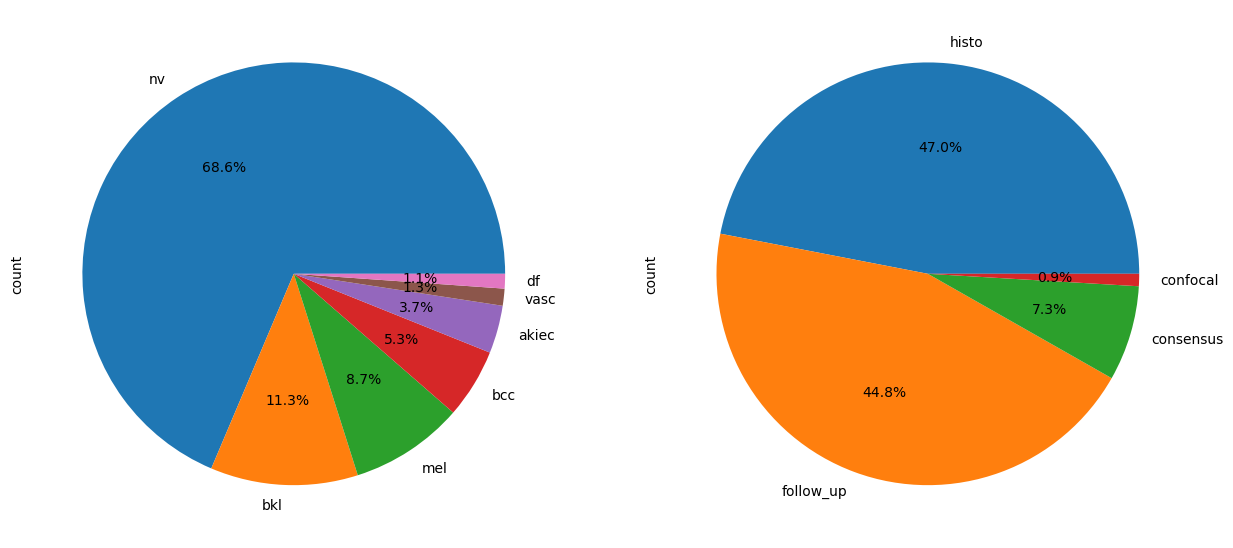

In [20]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
df['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.subplot(1,2,2)
df['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

1.  Type of skin disease:
    *     nv: Melanocytic nevi - 69.9%
    *     mel: Melanoma - 11.1 %
    *     bkl: Benign keratosis-like lesions - 11.0%
    *     bcc: Basal cell carcinoma - 5.1%
    *     akiec: Actinic keratoses- 3.3%
    *     vasc: Vascular lesions-1.4%
    *     df: Dermatofibroma - 1.1%

2. How the skin disease was discovered:
   * histo - histopathology - 53.3%
   * follow_up - follow up examination - 37.0%
   * consensus - expert consensus - 9.0%
   * confocal - confirmation by in-vivo confocal microscopy - 0.7%

### BIVARIATE ANALYSIS

<Axes: title={'center': 'LOCALIZATION VS GENDER'}, xlabel='count', ylabel='localization'>

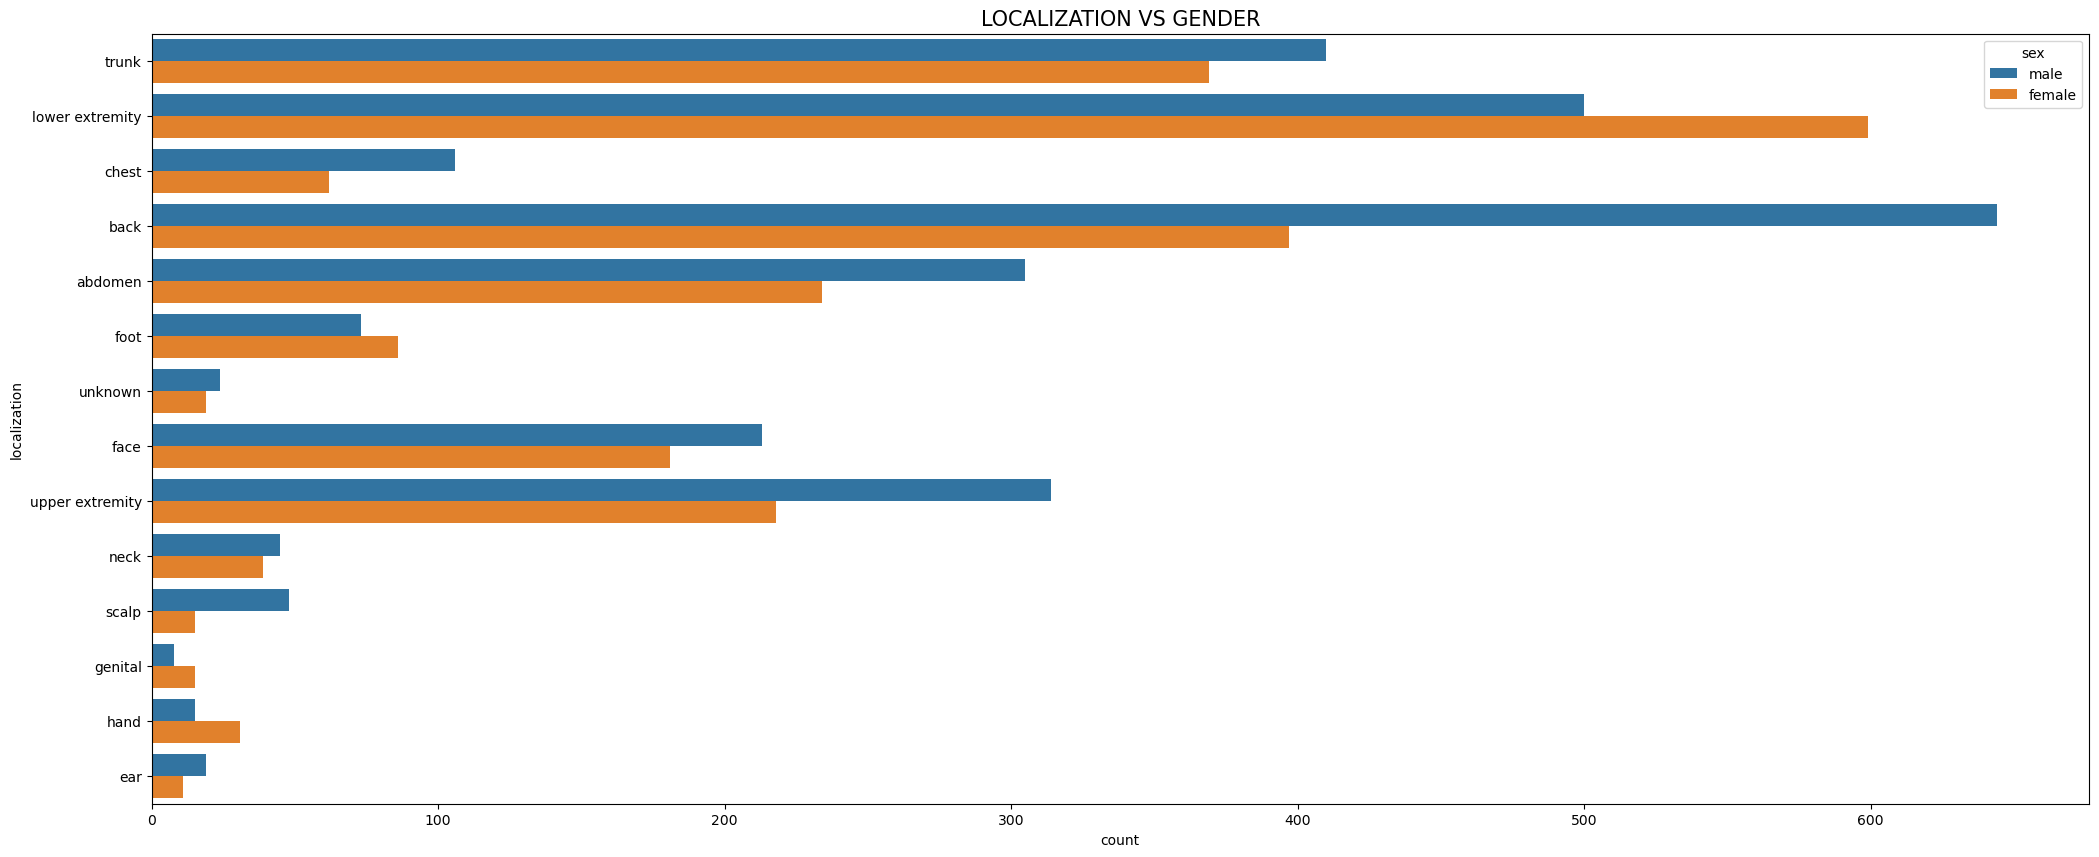

In [21]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS GENDER',fontsize = 15)
sns.countplot(y='localization', hue='sex',data=df)

* Back are is the most affected among people and more prominent in men.
* Infection on Lower extremity of the body is more visible in women.
* Some unknown regions also show infections and it's visible in men, women and other genders.
* The acral surfaces show the least infection cases that too in men only. Other gender groups don't show this kind of infection.


<Axes: title={'center': 'LOCALIZATION VS CELL TYPE'}, xlabel='count', ylabel='localization'>

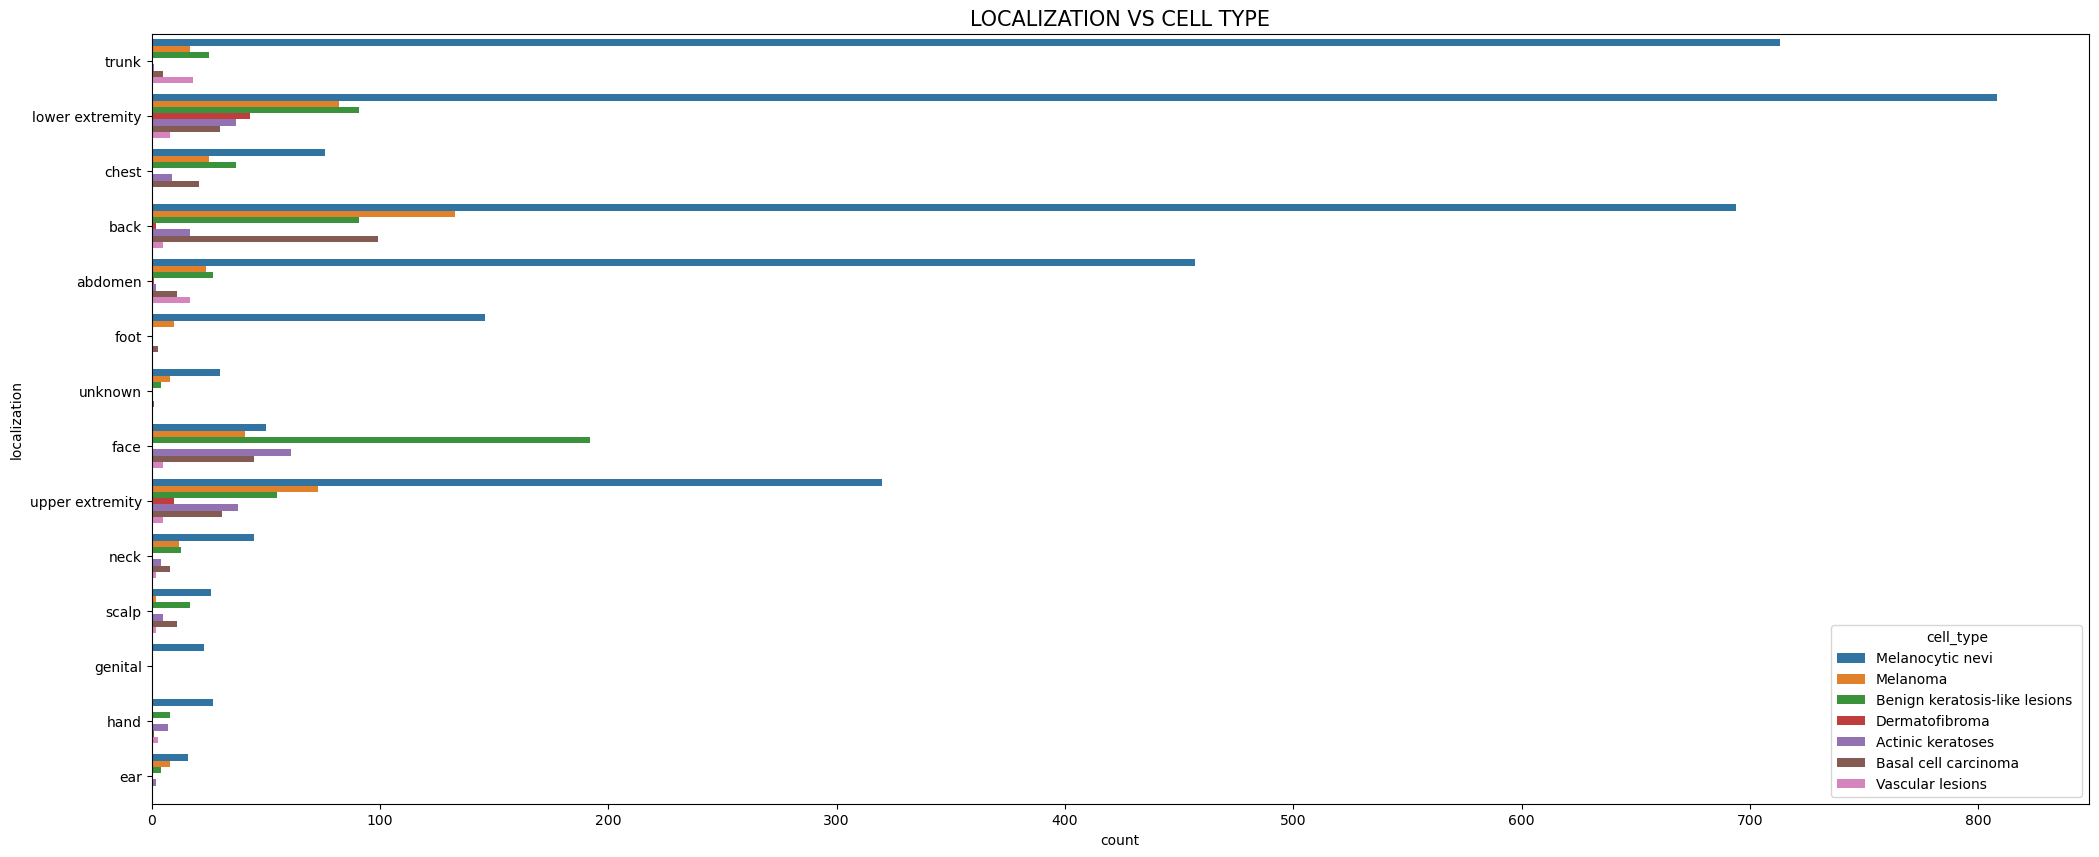

In [22]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS CELL TYPE',fontsize = 15)
sns.countplot(y='localization', hue='cell_type',data=df)

* The face is infected the most by Benign keratosis-like lesions.
* Body parts(except face) are infected the most by Melanocytic nevi.

<Axes: title={'center': 'GENDER VS CELL TYPE'}, xlabel='count', ylabel='sex'>

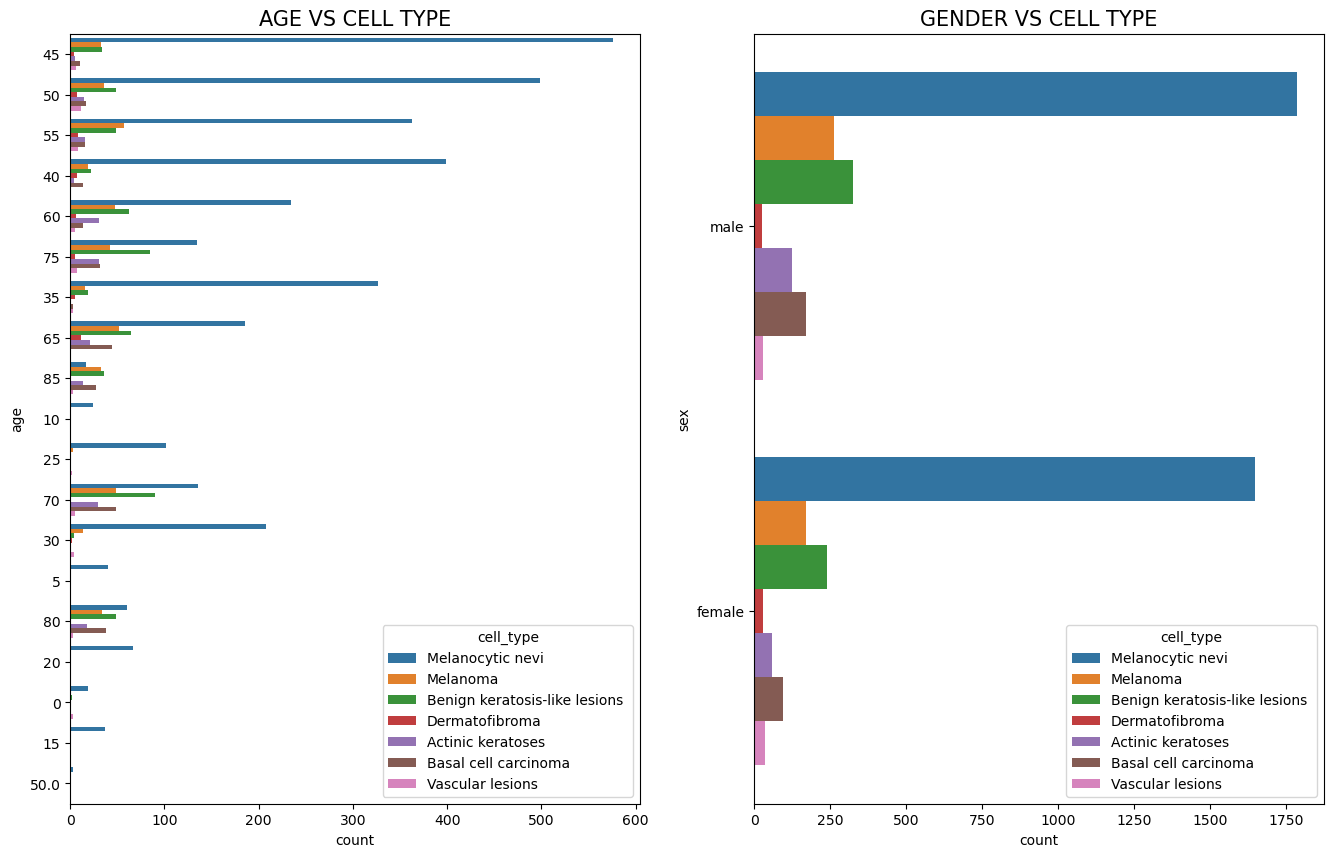

In [23]:
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.title('AGE VS CELL TYPE',fontsize = 15)
sns.countplot(y='age', hue='cell_type',data=df)
plt.subplot(132)
plt.title('GENDER VS CELL TYPE',fontsize = 15)
sns.countplot(y='sex', hue='cell_type',data=df)

1. The age group between 0-75 years is infected the most by Melanocytic nevi. On the other hand, the people aged 80-90 are affected more by Benign keratosis-like lesions.

2. All the gender groups are affected the most by Melanocytic nevi.

## **Training the model**

## model features preprocessing 

In [24]:
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [25]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [26]:
features.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,image
0,HAM_0000550,ISIC_0024306,nv,follow_up,45,male,trunk,hdfs://namenode:9000/project-data/HAM10000_ima...,Melanocytic nevi,"[[[27, 17, 20], [26, 16, 17], [28, 19, 21], [3..."
1,HAM_0003577,ISIC_0024307,nv,follow_up,50,male,lower extremity,hdfs://namenode:9000/project-data/HAM10000_ima...,Melanocytic nevi,"[[[80, 58, 67], [99, 71, 81], [107, 78, 91], [..."
2,HAM_0001477,ISIC_0024308,nv,follow_up,55,female,trunk,hdfs://namenode:9000/project-data/HAM10000_ima...,Melanocytic nevi,"[[[187, 182, 192], [163, 139, 139], [166, 170,..."
3,HAM_0000484,ISIC_0024309,nv,follow_up,40,male,trunk,hdfs://namenode:9000/project-data/HAM10000_ima...,Melanocytic nevi,"[[[208, 108, 107], [157, 64, 63], [218, 151, 1..."
4,HAM_0003350,ISIC_0024310,mel,histo,60,male,chest,hdfs://namenode:9000/project-data/HAM10000_ima...,Melanoma,"[[[241, 145, 149], [244, 150, 149], [242, 144,..."


In [27]:
target.head(10000)

0       4
1       4
2       4
3       4
4       5
       ..
4995    2
4996    2
4997    4
4998    4
4999    4
Name: cell_type_idx, Length: 5000, dtype: int8

In [28]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=666)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Benign keratosis-like lesions ', b'Basal cell carcinoma',
       b'Melanocytic nevi', b'Melanoma', b'Actinic keratoses',
       b'Vascular lesions', b'Dermatofibroma'], dtype=object)>, idx=<tf.Tensor: shape=(3750,), dtype=int32, numpy=array([0, 1, 2, ..., 4, 2, 2], dtype=int32)>)

In [29]:
# Normalization

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [30]:
x_train

array([[[[ 1.13330372e+00, -4.09288314e-01, -2.37889198e-01],
         [ 1.11187883e+00, -3.87863424e-01, -2.37889198e-01],
         [ 1.17615350e+00, -3.23588756e-01, -1.52189641e-01],
         ...,
         [ 1.28327795e+00, -3.02163867e-01,  4.06343641e-02],
         [ 1.26185306e+00, -3.23588756e-01,  4.06343641e-02],
         [ 1.30470284e+00, -2.59314088e-01,  1.04909032e-01]],

        [[ 1.13330372e+00, -3.87863424e-01, -2.16464309e-01],
         [ 1.13330372e+00, -3.66438535e-01, -1.95039419e-01],
         [ 1.11187883e+00, -3.87863424e-01, -1.95039419e-01],
         ...,
         [ 1.21900328e+00, -3.23588756e-01, -2.36403042e-02],
         [ 1.21900328e+00, -3.45013645e-01, -2.36403042e-02],
         [ 1.24042817e+00, -3.23588756e-01,  6.20592535e-02]],

        [[ 1.11187883e+00, -3.87863424e-01, -2.59314088e-01],
         [ 1.13330372e+00, -3.66438535e-01, -2.16464309e-01],
         [ 1.09045395e+00, -4.09288314e-01, -1.95039419e-01],
         ...,
         [ 1.17615350e+0

In [31]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
y_train_o.head()

3198    2
2985    1
2668    4
2015    1
501     4
Name: cell_type_idx, dtype: int8

In [32]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [33]:
# weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

# # Load the VGG16 model without the top (fully connected) layers and specify the weights path
# vgg_base = VGG16(weights=weights_path, include_top=False, input_shape=(100, 125, 3))

# # Freeze the base model
# vgg_base.trainable = False

# # Create a new model on top of it
# model = Sequential([
#     vgg_base,
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dense(7, activation='softmax') 
# ])

# model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=32)

# # Evaluate the mode
# loss, accuracy = model.evaluate(x_test, y_test)
# print(f'Test loss: {loss}')
# print(f'Test accuracy: {accuracy}')

In [34]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [35]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*3 -> Flatten -> Dense*2 -> Dropout -> Out
input_shape = (100,125, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 125, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 62, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 62, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 31, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,949,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067,239 (11.70 MB)

 Trainable params: 3,067,239 (11.70 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Define the optimizer
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [37]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [38]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [ ]:
from tensorflow.keras.metrics import Recall
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
# Fit the model
epochs = 10
batch_size = 32
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

In [ ]:
import itertools
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 


In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [ ]:
# # Function to plot model's validation loss and validation accuracy
# def plot_model_history(model_history):
#     fig, axs = plt.subplots(1,2,figsize=(15,5))
#     # summarize history for accuracy
#     axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
#     axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
#     axs[0].set_title('Model Accuracy')
#     axs[0].set_ylabel('Accuracy')
#     axs[0].set_xlabel('Epoch')
#     axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
#     axs[0].legend(['train', 'val'], loc='best')
#     # summarize history for loss
#     axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
#     axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
#     axs[1].set_title('Model Loss')
#     axs[1].set_ylabel('Loss')
#     axs[1].set_xlabel('Epoch')
#     axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
#     axs[1].legend(['train', 'val'], loc='best')
#     plt.show()
# plot_model_history(history)

## **ANN**

### A simple neural network is implemented first with the following layers to get patterns in images. The accuracy achieved is approximately 69 percent.


In [ ]:
# FOR CNN AND ANN

x_train = x_train.reshape(6696,125*100*3)
x_test = x_test.reshape(2481,125*100*3)
print(x_train.shape)
print(x_test.shape)

In [ ]:
# define the keras model
model = Sequential()

model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu', input_dim = 37500))
model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

# compile the keras model
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# fit the keras model on the dataset
history = model.fit(x_train, y_train, batch_size = 10, epochs = 18) # changed from 50

accuracy = model.evaluate(x_test, y_test, verbose=1)[1]
print("Test: accuracy = ",accuracy*100,"%")

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)